<a href="https://colab.research.google.com/github/Apple03244/Colaboratory/blob/main/TensorBoard_%26tuningipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model Load

In [1]:
import google.colab as colab

In [2]:
! unzip /content/titanic_predictor.zip

Archive:  /content/titanic_predictor.zip
   creating: content/titanic_predictor/
  inflating: content/titanic_predictor/keras_metadata.pb  
   creating: content/titanic_predictor/assets/
 extracting: content/titanic_predictor/fingerprint.pb  
   creating: content/titanic_predictor/variables/
  inflating: content/titanic_predictor/variables/variables.index  
  inflating: content/titanic_predictor/variables/variables.data-00000-of-00001  
  inflating: content/titanic_predictor/saved_model.pb  


In [3]:
import tensorflow as tf
import tensorflow.keras as tk

In [4]:
predictor=tk.models.load_model("/content/content/titanic_predictor")

In [5]:
!pip install -q -U tensorboard-plugin-profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.8 MB/s eta 0:00:00


### Needs

텐서보드를 활성화 하려면 프로그램을 수정하여 이벤트 파일이라고 특별한 이진로그 파일에 시각화하려는 데이터를 출력해야함

다행히 `tensorflow.keras.callbacks.TensorBoard` 메소드가 자동으로 위의 필요과정을 진행해준다

In [6]:
clone_predictor=tk.models.clone_model(predictor)

### 모델 구조 살피기

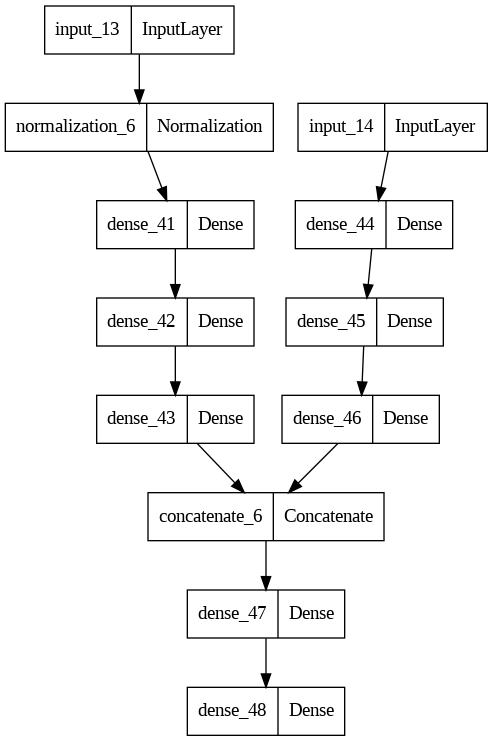

In [7]:
tk.utils.plot_model(clone_predictor)

### 모델을 수정해보자

In [19]:
files=colab.files.upload()

Saving custom_module.py to custom_module.py


In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic
!unzip /content/titanic.zip

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 45.5MB/s]
Archive:  /content/titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [10]:
import pandas as pd
train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")
submission=pd.read_csv("/content/gender_submission.csv")

## hyper Parameter tuning

by unsing `Keras Tuner`

장점 : 텐서보드와의 연동성이 굉장히 좋음

따라서 튜닝 후 tensorboard로 시각화해보는 것을 목표로 하겠다

In [11]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.2 MB/s eta 0:00:00


In [22]:
import keras_tuner as kt
import joblib
from custom_module import passth

In [24]:
preprocessing_pipeline=joblib.load('/content/preprocessing_pipeline.pkl')

In [26]:
preprocessing_pipeline.fit(X=train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer',
                                                  KNNImputer(n_neighbors=10))]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked']),
                                ('passth', passth(), ['Survived', 'Pclass'])])

In [27]:
column_name=[]
for x in preprocessing_pipeline.named_transformers_:
  try:
    column_name.extend(preprocessing_pipeline.named_transformers_[x].get_feature_names_out())
  except:
    continue

In [29]:
pre_train=pd.DataFrame(data=preprocessing_pipeline.transform(X=train)
,columns=column_name)

In [30]:
pre_train

,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Survived,Pclass
0,22.0,1.0,0.0,7.2500,1.0,0.0,1.0,0.0,3.0
1,38.0,1.0,0.0,71.2833,0.0,0.0,0.0,1.0,1.0
2,26.0,0.0,0.0,7.9250,0.0,0.0,1.0,1.0,3.0
3,35.0,1.0,0.0,53.1000,0.0,0.0,1.0,1.0,1.0
4,35.0,0.0,0.0,8.0500,1.0,0.0,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...
886,27.0,0.0,0.0,13.0000,1.0,0.0,1.0,0.0,2.0
887,19.0,0.0,0.0,30.0000,0.0,0.0,1.0,1.0,1.0
888,24.8,1.0,2.0,23.4500,0.0,0.0,1.0,0.0,3.0
889,26.0,0.0,0.0,30.0000,1.0,0.0,0.0,1.0,1.0


## 모델 개선을 위해 기존 틀을 참고한 모델링 준비

#### keras tuner를 이용하기 위한 준비

keras_tuner.HyperParmeters 를 받게 되기 떄문에 아래와 같은 방법이 필요하다

In [34]:
tk.optimizers.SGD

<function keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters.Int(self, name, min_value, max_value, step=None, sampling='linear', default=None, parent_name=None, parent_values=None)>

굉장히 복잡한 wide$deep model을 구성할 것이므로

In [50]:
from pathlib import Path
from time import strftime
def get_run_logdir(root_logdir="my_logs"):
  return Path(root_logdir)/strftime("run8ySm_Rd_H_MSS")
run_logdir= get_run_logdir()# 예: my_logs/run_2022_08_01.17_25_59

In [108]:
def build_model(x):
  # 은닉층 깊이
  n_num_hidden=x.Int("n_num_hidden",min_value=1,max_value=5)
  n_cate_hidden=x.Int("n_cate_hidden",min_value=1,max_value=5)
  # 뉴런 개수
  n_num_neuro=x.Int("n_num_neuro",min_value=16,max_value=256)
  n_cate_neuro=x.Int("n_cate_neuro",min_value=8,max_value=256)
  # 학습률
  learning_rate=x.Float("learning_rate",min_value=1e-6,max_value=1e-2,sampling="log")

  #choice : 이름으로 우선 전달해서 고르게 해야함
  optimizer=x.Choice("optimizer",values=["adam","sgd"])

  if optimizer=="adam":
    optimizer=tk.optimizers.Adam(learning_rate=learning_rate)
  if optimizer=="sgd":
    optimizer=tk.optimizers.SGD(learning_rate=learning_rate)


  # Modeling
  num_input=tk.layers.Input(shape=[4])
  cate_input=tk.layers.Input(shape=[4])
  # Normalization
  num_norm_input=tk.layers.BatchNormalization()(num_input) #배치정규화는 분산과 평균을 추적하기 때문에 adapt 메소드가 필요없음

  # numeric_deep
  num_deep=num_input
  for _ in range(n_num_hidden):
    num_deep=tk.layers.Dense(n_num_hidden,activation="relu")(num_deep)
  # category_deep
  cate_deep=cate_input
  for _ in range(n_cate_hidden):
    cate_deep=tk.layers.Dense(n_cate_hidden,activation="sigmoid")(cate_deep)

  # concate
  concate=tk.layers.Concatenate()([num_input,cate_input,num_deep,cate_deep])
  output=tk.layers.Dense(1,activation="sigmoid")(concate)

  Model=tk.Model(inputs=(num_input,cate_input),outputs=output)

  # compile
  loss=tk.losses.BinaryCrossentropy()
  metrics_=tk.metrics.BinaryAccuracy()
  Model.compile(optimizer=optimizer,loss=loss,metrics=[metrics_])

  return Model

In [109]:
random_search_tuner=kt.RandomSearch(build_model,objective="val_binary_accuracy",max_trials=5,
                                    overwrite=True,directory="My_Titanic",project_name="random_search_titanic",seed=10)

In [110]:
num_col=["Age","SibSp","Parch","Fare"]
cate_col=["Sex_male","Embarked_Q","Embarked_S","Pclass"]

In [111]:
total_test=pd.merge(test,submission)
preprocessing_pipeline.fit(total_test)
column_name=[]
for x in preprocessing_pipeline.named_transformers_:
  try:
    column_name.extend(preprocessing_pipeline.named_transformers_[x].get_feature_names_out())
  except:
    continue

pre_test=pd.DataFrame(data=preprocessing_pipeline.transform(total_test),columns=column_name)

In [112]:
random_search_tuner.search((pre_train[num_col],pre_train[cate_col]),pre_train["Survived"],epochs=100
                           ,validation_split=0.2)

Trial 5 Complete [00h 00m 23s]
val_binary_accuracy: 0.7262569665908813

Best val_binary_accuracy So Far: 0.832402229309082
Total elapsed time: 00h 01m 30s


In [ ]:
help(tk.callbacks.EarlyStopping)
callbacks=tk.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
  tensorboard=tk.callbacks.TensorBoard(run_logdir,profile_batch=(100,200))
,callbacks=[callbacks,tensorboard],

In [75]:
tk.Model.fit

<function keras.engine.training.Model.fit(self, x=None, y=None, batch_size=None, epochs=1, verbose='auto', callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_batch_size=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)>